# Liver Model

## Import some things

In [1]:
from Liver_Generator import Data_Generator, os, plot_scroll_Image, dice_coef_3D
from Utils import ModelCheckpoint, TensorBoardImage, model_path_maker

Using TensorFlow backend.


In [10]:
%matplotlib inline

In [3]:
%load_ext tensorboard

In [4]:
data_path = os.path.join('..','Data','Niftii_Arrays')
train_path = os.path.join(data_path,'Train')
validation_path = os.path.join(data_path,'Validation')
test_path = os.path.join(data_path,'Test')
model_path = os.path.join('..','Models')
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [7]:
args = {'batch_size':5,'on_vgg':True}#'mean_val':81,'std_val':31,
train_generator = Data_Generator(train_path, shuffle=True, **args) # mean_val=81,std_val=30

## Normalize images about the mask to be mean 0, std 1

In [6]:
train_generator.get_mean_std_val() # This will calculate the mean and std for you and set it in the model
print(train_generator.mean_val)

Calculating mean and std...0% done
Calculating mean and std...0% done
Calculating mean and std...1% done
Calculating mean and std...1% done
Calculating mean and std...1% done
Calculating mean and std...1% done
Calculating mean and std...2% done
Calculating mean and std...2% done
Calculating mean and std...2% done
Calculating mean and std...2% done
Calculating mean and std...3% done
Calculating mean and std...3% done
Calculating mean and std...3% done
Calculating mean and std...3% done
Calculating mean and std...4% done
Calculating mean and std...4% done
Calculating mean and std...4% done
Calculating mean and std...5% done
Calculating mean and std...5% done
Calculating mean and std...5% done
Calculating mean and std...5% done
Calculating mean and std...6% done
Calculating mean and std...6% done
Calculating mean and std...6% done
Calculating mean and std...6% done
Calculating mean and std...7% done
Calculating mean and std...7% done
Calculating mean and std...7% done
Calculating mean and

SystemError: <built-in function ReadImage> returned a result with an error set

In [8]:
args_val = {'on_vgg':True,'mean_val':train_generator.mean_val,'std_val':train_generator.std_val,'by_patient':False,
       'shuffle':True,'batch_size':30}#'mean_val':81,'
validation_generator = Data_Generator(validation_path, **args_val)
args_val = {'on_vgg':True,'mean_val':train_generator.mean_val,'std_val':train_generator.std_val,'by_patient':True,
       'shuffle':False}
test_generator = Data_Generator(test_path, **args_val)

In [9]:
x,y = train_generator.__getitem__(0)

<IPython.core.display.Javascript object>


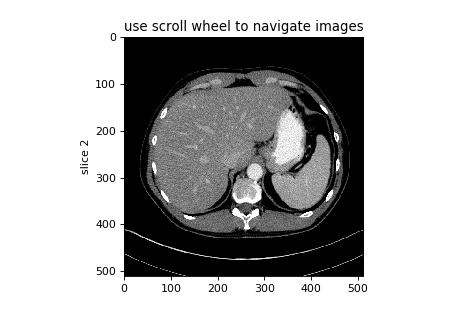

(<Figure size 432x288 with 1 Axes>,
 <Dicom_RT_and_Images_to_Mask.Image_Array_And_Mask_From_Dicom_RT.IndexTracker at 0x1b923e3d128>)

In [11]:
plot_scroll_Image(x[...,-1])

In [12]:
x,y = validation_generator.__getitem__(0)

### Alright, lets make our model!

In [13]:
from Easy_VGG16_UNet.Keras_Fine_Tune_VGG_16_Liver import VGG_16
from Visualizing_Model.Visualing_Model import visualization_model_class
from keras.optimizers import Adam

In [ ]:
network = {'Layer_0': {'Encoding': [64, 64], 'Decoding': [32]},
           'Layer_1': {'Encoding': [128, 128], 'Decoding': [64]},
           'Layer_2': {'Encoding': [256, 256, 256], 'Decoding': [256]},
           'Layer_3': {'Encoding': [512, 512, 512], 'Decoding': [256]},
           'Layer_4': {'Encoding': [512, 512, 512]}}
VGG_model = VGG_16(network=network, activation='relu',filter_size=(3,3))
VGG_model.make_model()
VGG_model.load_weights()
new_model = VGG_model.created_model
model_path = os.path.join('..','Models')

## These are some tools for visualizing the model

In [ ]:
Visualizing_Class = visualization_model_class(model=new_model, save_images=True, verbose=True)

In [ ]:
Visualizing_Class.define_desired_layers(['block1_conv1','block1_conv1_activation','Output'])

In [ ]:
Visualizing_Class.predict_on_tensor(x[0,...][None,...])

In [ ]:
Visualizing_Class.plot_activations()

In [ ]:
new_model.compile(Adam(lr=5e-5),loss='categorical_crossentropy', metrics=['accuracy',dice_coef_3D])

### Freezing pre-trained layers

In [ ]:
def freeze_until_name(model,name):
    set_trainable = False
    for layer in model.layers:
        if layer.name == name:
            set_trainable = True
        layer.trainable = set_trainable
    return model
new_model = freeze_until_name(new_model,'Upsampling0_UNet')

### Now that our model is made, lets name it and make a checkpoint as it trains

A checkpoint is a way of assessing the model and determining if we should save it

In [ ]:
model_name = 'VGG_16_Model'
other_aspects = [model_name,'Upsampling0_UNet_Unfrozen'] # Just a list of defining things
model_path_out = model_path_maker(model_path,other_aspects)

In [ ]:
checkpoint = ModelCheckpoint(model_path_out, monitor='val_dice_coef_3D', verbose=1, save_best_only=True,
                              save_weights_only=False, period=5, mode='max')
# TensorboardImage lets us view the predictions of our model
tensorboard = TensorBoardImage(log_dir=model_path_out, batch_size=1, num_images=3,update_freq='epoch', 
                               data_generator=validation_generator)
callbacks = [checkpoint, tensorboard]

In [ ]:
%tensorboard --logdir {model_path}

In [ ]:
new_model.fit_generator(train_generator,epochs=5, workers=20, max_queue_size=50, validation_data=validation_generator,
                       callbacks=callbacks)

In [ ]:
x,y = validation_generator.__getitem__(0)

In [ ]:
pred = new_model.predict(x)

In [ ]:
pred[pred<0.5] = 0
pred[pred>0] = 1

In [ ]:
plot_scroll_Image(pred[...,1])

# Now lets make our own architecture

In [14]:
from UNet_Maker import my_UNet
from functools import partial

In [15]:
layers_dict = {}

In [16]:
conv_block = lambda x: {'Channels': [x], 'Kernel': [(3, 3)]}
pool = (4,4)
filters = 16
layers_dict['Layer_0'] = {'Encoding':[conv_block(filters), conv_block(filters)],'Pooling':(4,4),
                         'Decoding':[conv_block(filters),conv_block(filters)]}
pool = (2,2)
filters = 32
layers_dict['Layer_1'] = {'Encoding':[conv_block(filters), conv_block(filters)],'Pooling':pool,
                         'Decoding':[conv_block(filters),conv_block(filters)]}
filters = 64
layers_dict['Base'] = {'Encoding':[conv_block(filters), conv_block(filters)]}

In [24]:
new_model = my_UNet(layers_dict=layers_dict,image_size=512,num_channels=train_generator.channels).created_model
new_model.compile(Adam(lr=1e-6),loss='categorical_crossentropy', metrics=['accuracy',dice_coef_3D])

W1028 13:58:49.351475 24864 deprecation_wrapper.py:119] From C:\Users\bmanderson\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1028 13:58:49.356488 24864 deprecation_wrapper.py:119] From C:\Users\bmanderson\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



Layer_0
Layer_1
Base
Layer_1
Layer_0


In [25]:
model_name = 'My_New_Model'
other_aspects = [model_name,'3_Layers','16_filters'] # Just a list of defining things
model_path_out = model_path_maker(model_path,other_aspects)

In [26]:
checkpoint = ModelCheckpoint(model_path_out, monitor='val_dice_coef_3D', verbose=1, save_best_only=True,
                              save_weights_only=False, period=5, mode='max')
# TensorboardImage lets us view the predictions of our model
tensorboard = TensorBoardImage(log_dir=model_path_out, batch_size=1,update_freq='epoch', 
                               data_generator=validation_generator)
callbacks = [checkpoint, tensorboard]

In [ ]:
new_model.fit_generator(train_generator,epochs=5, workers=20, max_queue_size=50, validation_data=validation_generator,
                       callbacks=callbacks, steps_per_epoch=10)

Epoch 1/5
 9/10 [==========================>...] - ETA: 7s - loss: 9.1627 - acc: 0.0942 - dice_coef_3D: 0.0960 